In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
#from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
from xgboost import plot_importance
import multiprocessing
import random
import tensorflow as tf
from multiprocessing import Pool
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
data = pd.read_csv("Predict Hair Fall.csv")
print(data) #导入脱发数据集并展示

         Id Genetics Hormonal Changes     Medical Conditions  \
0    133992      Yes               No                No Data   
1    148393       No               No                 Eczema   
2    155074       No               No             Dermatosis   
3    118261      Yes              Yes               Ringworm   
4    111915       No               No              Psoriasis   
..      ...      ...              ...                    ...   
994  184367      Yes               No  Seborrheic Dermatitis   
995  164777      Yes              Yes                No Data   
996  143273       No              Yes  Androgenetic Alopecia   
997  169123       No              Yes             Dermatitis   
998  127183      Yes              Yes              Psoriasis   

      Medications & Treatments Nutritional Deficiencies     Stress  Age  \
0                      No Data      Magnesium deficiency  Moderate   19   
1                  Antibiotics      Magnesium deficiency      High   43   
2     

In [2]:
#检查数据，确保无缺失值、无重复值
isna= data.isna().sum()
dup= data.duplicated().sum()
print("-----------Number of NA Value-----------")
print(isna)
print("-----------Number of Duplicated Value-----------")
print(dup)

-----------Number of NA Value-----------
Id                           0
Genetics                     0
Hormonal Changes             0
Medical Conditions           0
Medications & Treatments     0
Nutritional Deficiencies     0
Stress                       0
Age                          0
Poor Hair Care Habits        0
Environmental Factors        0
Smoking                      0
Weight Loss                  0
Hair Loss                    0
dtype: int64
-----------Number of Duplicated Value-----------
0


In [3]:
import matplotlib.pyplot as plt
#样本数据集平均年龄
average_age = data["Age"].mean()
print("-----------Average Old of Sample-----------")
formatted_average_age = f"{average_age:.2f}" #平均年龄保留小数点后两位
print(formatted_average_age,"years old")

#分别收集样本数据集年龄维度的最大值、最小值，为下一步做准备
max_age = data["Age"].max()
min_age = data["Age"].min()
print("-----------Maximum Old of Sample-----------")
print(max_age,"years old")
print("-----------Minimum Old of Sample-----------")
print(min_age,"years old")


-----------Average Old of Sample-----------
34.19 years old
-----------Maximum Old of Sample-----------
50 years old
-----------Minimum Old of Sample-----------
18 years old


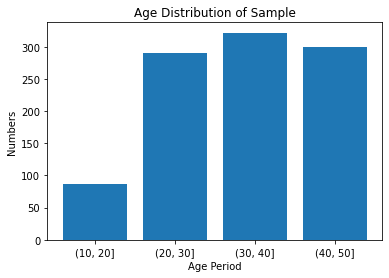

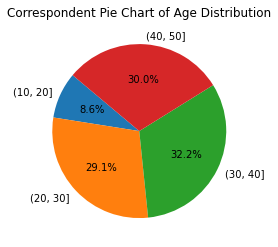

In [4]:
#样本数据及年龄的分布情况
#柱状图展示
age_period = [10,20,30,40,50]  #根据上段代码结论设置年龄段的区间
age_groups = pd.cut(data["Age"],bins=age_period)
age_group_counts = age_groups.value_counts().sort_index()
plt.bar(age_group_counts.index.astype(str),age_group_counts)
plt.xlabel("Age Period")
plt.ylabel("Numbers")
plt.title("Age Distribution of Sample")
plt.show()


#饼图展示
plt.pie(age_group_counts, labels= age_group_counts.index.astype(str),autopct="%1.1f%%",startangle=140)
plt.title("Correspondent Pie Chart of Age Distribution")
plt.show()



In [5]:
#常见医疗条件发生频率分析
freq_counts= data["Medical Conditions"].value_counts()
freq_cy= freq_counts/freq_counts.sum()
freq_percentage_integer_old= freq_cy*100
freq_percentage_integer_new= round(freq_percentage_integer_old,2) #数字部分保留两位小数
freq_percentage_raw= freq_percentage_integer_new.astype(str)+"%"

data_dict= {"Frequency Counts":freq_counts,
            "Frequency":freq_percentage_raw
           }
df= pd.DataFrame(data_dict)
print(df)


                       Frequency Counts Frequency
No Data                             110    11.01%
Alopecia Areata                     107    10.71%
Psoriasis                           100    10.01%
Thyroid Problems                     99     9.91%
Androgenetic Alopecia                98     9.81%
Dermatitis                           92     9.21%
Dermatosis                           88     8.81%
Seborrheic Dermatitis                88     8.81%
Scalp Infection                      79     7.91%
Eczema                               69     6.91%
Ringworm                             69     6.91%


In [6]:
df.index

Index(['No Data', 'Alopecia Areata ', 'Psoriasis', 'Thyroid Problems',
       'Androgenetic Alopecia', 'Dermatitis', 'Dermatosis',
       'Seborrheic Dermatitis', 'Scalp Infection', 'Eczema', 'Ringworm'],
      dtype='object')

                       Frequency Counts Frequency
No Data                             110    11.01%
Alopecia Areata                     107    10.71%
Psoriasis                           100    10.01%
Thyroid Problems                     99     9.91%
Androgenetic Alopecia                98     9.81%
Dermatitis                           92     9.21%
Dermatosis                           88     8.81%
Seborrheic Dermatitis                88     8.81%
Scalp Infection                      79     7.91%
Eczema                               69     6.91%
Ringworm                             69     6.91%


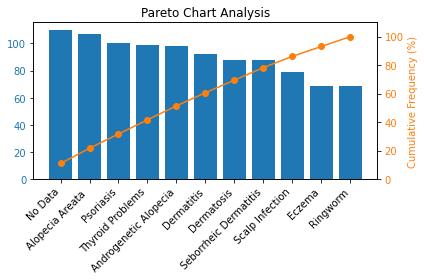

In [7]:
#上述问题使用帕累托图探究主要原因
#第一部分：柱状图部分降序展示频数
df= df.sort_values(by="Frequency Counts",ascending= False)
print(df)
fig,ax1=plt.subplots()
ax1.bar(df.index,df["Frequency Counts"],color="C0")
ax1.set_xlabel= ("No Data")
ax1.set_ylabel= ("Frequency Counts")
ax1.tick_params(axis="y",labelcolor="C0")
plt.xticks(rotation=45,ha="right")  #旋转45度，使得横坐标长字符标签能看得清

#第二部分：条形图部分展示频率
cumulative_freq = np.cumsum(df["Frequency Counts"])/df["Frequency Counts"].sum()*100
ax2 = ax1.twinx()
ax2.plot(df.index, cumulative_freq, color="C1", marker="o", linestyle="-")
ax2.set_ylabel("Cumulative Frequency (%)", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")
ax2.set_ylim([0, 110])  # 设定y轴的范围从0到110，保证图像显示美观

plt.title("Pareto Chart Analysis")
plt.tight_layout()
plt.show()

In [8]:
#营养缺乏的种类及其出现频率分析
freq_counts= data["Nutritional Deficiencies "].value_counts()  #注意这里引号内部最后有空格，好像是和原表格列名最后有空格有关
freq_cy= freq_counts/freq_counts.sum()
freq_percentage_integer_old= freq_cy*100
freq_percentage_integer_new= round(freq_percentage_integer_old,2) #数字部分保留两位小数
freq_percentage_raw= freq_percentage_integer_new.astype(str)+"%"

data_dict= {"Frequency Counts":freq_counts,
            "Frequency":freq_percentage_raw
           }
df= pd.DataFrame(data_dict)
print(df)

                      Frequency Counts Frequency
Zinc Deficiency                    108    10.81%
Vitamin D Deficiency               104    10.41%
Biotin Deficiency                   99     9.91%
Vitamin A Deficiency                99     9.91%
Omega-3 fatty acids                 92     9.21%
Protein deficiency                  90     9.01%
Magnesium deficiency                84     8.41%
Vitamin E deficiency                83     8.31%
Selenium deficiency                 82     8.21%
No Data                             80     8.01%
Iron deficiency                     78     7.81%


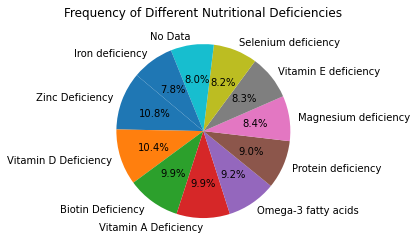

In [9]:
#使用饼图表示上述频率
plt.pie(freq_cy,labels=freq_cy.index.astype(str),autopct="%1.1f%%",startangle=140)
plt.title("Frequency of Different Nutritional Deficiencies")
plt.show()

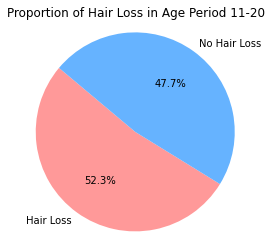

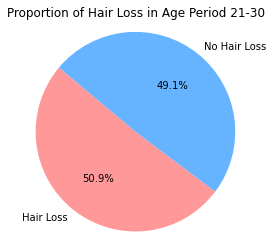

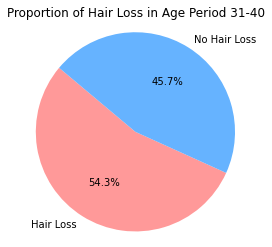

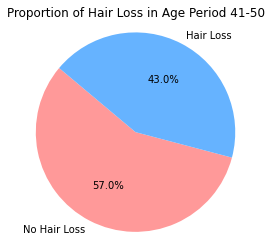

In [10]:
#不同年龄段患者脱发比例分析
#(10-20]年龄段患者脱发比例，并用饼图表示
ds_1= data[(data["Age"]>=10)&(data["Age"]<=20)]
hair_loss_counts_1= ds_1["Hair Loss"].value_counts()

plt.figure(figsize=(4,4))
plt.pie(hair_loss_counts_1,labels=["Hair Loss","No Hair Loss"],
        autopct= "%1.1f%%",startangle= 140,
        colors=["#ff9999","#66b3ff"])
plt.title("Proportion of Hair Loss in Age Period 11-20")
plt.axis("equal")
plt.show()
#(20-30]年龄段患者脱发比例，并用饼图表示
ds_2= data[(data["Age"]>20)&(data["Age"]<=30)]
hair_loss_counts_2= ds_2["Hair Loss"].value_counts()

plt.figure(figsize=(4,4))
plt.pie(hair_loss_counts_2,labels=["Hair Loss","No Hair Loss"],
        autopct= "%1.1f%%",startangle= 140,
        colors=["#ff9999","#66b3ff"])
plt.title("Proportion of Hair Loss in Age Period 21-30")
plt.axis("equal")
plt.show()
#(30-40]年龄段患者脱发比例，并用饼图表示
ds_3= data[(data["Age"]>30)&(data["Age"]<=40)]
hair_loss_counts_3= ds_3["Hair Loss"].value_counts()

plt.figure(figsize=(4,4))
plt.pie(hair_loss_counts_3,labels=["Hair Loss","No Hair Loss"],
        autopct= "%1.1f%%",startangle= 140,
        colors=["#ff9999","#66b3ff"])
plt.title("Proportion of Hair Loss in Age Period 31-40")
plt.axis("equal")
plt.show()
#(40-50]年龄段患者脱发比例，并用饼图表示
ds_4= data[(data["Age"]>40)&(data["Age"]<=50)]
hair_loss_counts_4= ds_4["Hair Loss"].value_counts()

plt.figure(figsize=(4,4))
plt.pie(hair_loss_counts_4,labels=["No Hair Loss","Hair Loss"],
        autopct= "%1.1f%%",startangle= 140,
        colors=["#ff9999","#66b3ff"])
plt.title("Proportion of Hair Loss in Age Period 41-50")
plt.axis("equal")
plt.show()


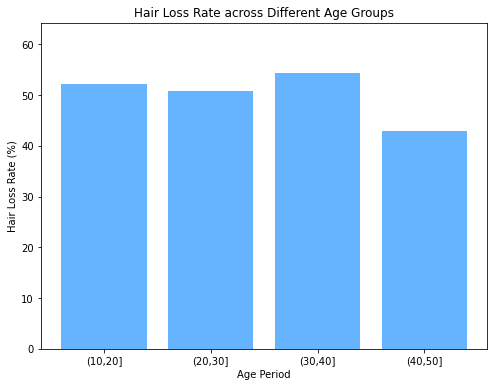

In [11]:
#以上脱发比例合并到同一柱状图，横标签为上述年龄段
# 计算脱发比例（数值格式）
hair_loss_rate_1 = hair_loss_counts_1[1] / hair_loss_counts_1.sum() * 100
hair_loss_rate_1 = round(hair_loss_rate_1, 1)

hair_loss_rate_2 = hair_loss_counts_2[1] / hair_loss_counts_2.sum() * 100
hair_loss_rate_2 = round(hair_loss_rate_2, 1)

hair_loss_rate_3 = hair_loss_counts_3[1] / hair_loss_counts_3.sum() * 100
hair_loss_rate_3 = round(hair_loss_rate_3, 1)

hair_loss_rate_4 = hair_loss_counts_4[1] / hair_loss_counts_4.sum() * 100
hair_loss_rate_4 = round(hair_loss_rate_4, 1)

age_groups = ["(10,20]", "(20,30]", "(30,40]", "(40,50]"]
hair_loss_rates = [hair_loss_rate_1, hair_loss_rate_2, hair_loss_rate_3, hair_loss_rate_4]

# 绘制柱状图
plt.figure(figsize=(8, 6))  # 适当调整图表大小
plt.bar(age_groups, hair_loss_rates, color="#66b3ff")
plt.xlabel("Age Period")
plt.ylabel("Hair Loss Rate (%)")
plt.title("Hair Loss Rate across Different Age Groups")
plt.ylim(0, max(hair_loss_rates) + 10)  # 适当调整y轴上限以适应数据
plt.show()

In [12]:
#脱发关联性分析
#表格进一步预处理
data_new= data.drop("Id",axis=1)  #删除与关联性探讨无关的Id这一列
#data_new_0= data_new.apply(pd.to_numeric,errors="coerce")
data_new


,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...
994,Yes,No,Seborrheic Dermatitis,Rogaine,Vitamin A Deficiency,Low,33,Yes,Yes,Yes,Yes,1
995,Yes,Yes,No Data,Accutane,Protein deficiency,Low,47,No,No,No,Yes,0
996,No,Yes,Androgenetic Alopecia,Antidepressants,Protein deficiency,Moderate,20,Yes,No,Yes,Yes,1
997,No,Yes,Dermatitis,Immunomodulators,Biotin Deficiency,Moderate,32,Yes,Yes,Yes,Yes,1


In [13]:
#脱发关联性分析
#分类变量之间使用卡方类检验（列联表+卡方检验），显著性水平：alpha=0.05
contingency_table= pd.crosstab(data_new["Genetics"],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:1.5433285346248653
P-Value:0.21412303866996626
Degrees of Freedom:1
Expected Frequencies:
[[239.69369369 237.30630631]
 [262.30630631 259.69369369]]


In [14]:
contingency_table= pd.crosstab(data_new["Hormonal Changes"],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:0.025996034340852625
P-Value:0.8719100031066214
Degrees of Freedom:1
Expected Frequencies:
[[246.22622623 243.77377377]
 [255.77377377 253.22622623]]


In [15]:
contingency_table= pd.crosstab(data_new["Medical Conditions"],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:9.812280542249438
P-Value:0.45711419686494104
Degrees of Freedom:10
Expected Frequencies:
[[53.76776777 53.23223223]
 [49.24524525 48.75475475]
 [46.23023023 45.76976977]
 [44.22022022 43.77977978]
 [34.67267267 34.32732733]
 [55.27527528 54.72472472]
 [50.25025025 49.74974975]
 [34.67267267 34.32732733]
 [39.6976977  39.3023023 ]
 [44.22022022 43.77977978]
 [49.74774775 49.25225225]]


In [16]:
contingency_table= pd.crosstab(data_new["Medications & Treatments"],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:3.6850359380726467
P-Value:0.9604391135042174
Degrees of Freedom:10
Expected Frequencies:
[[51.25525526 50.74474474]
 [47.23523524 46.76476476]
 [55.27527528 54.72472472]
 [47.23523524 46.76476476]
 [45.22522523 44.77477477]
 [45.22522523 44.77477477]
 [52.26026026 51.73973974]
 [45.22522523 44.77477477]
 [ 1.00500501  0.99499499]
 [58.29029029 57.70970971]
 [53.76776777 53.23223223]]


In [17]:
contingency_table= pd.crosstab(data_new["Nutritional Deficiencies "],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:3.4200112641715505
P-Value:0.96974477918253
Degrees of Freedom:10
Expected Frequencies:
[[49.74774775 49.25225225]
 [39.1951952  38.8048048 ]
 [42.21021021 41.78978979]
 [40.2002002  39.7997998 ]
 [46.23023023 45.76976977]
 [45.22522523 44.77477477]
 [41.20520521 40.79479479]
 [49.74774775 49.25225225]
 [52.26026026 51.73973974]
 [41.70770771 41.29229229]
 [54.27027027 53.72972973]]


In [18]:
contingency_table= pd.crosstab(data_new["Stress"],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:0.9565232880531387
P-Value:0.6198599930985773
Degrees of Freedom:2
Expected Frequencies:
[[161.3033033  159.6966967 ]
 [164.31831832 162.68168168]
 [176.37837838 174.62162162]]


In [19]:
contingency_table= pd.crosstab(data_new["Poor Hair Care Habits "],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:1.376281880823514
P-Value:0.24073549493781138
Degrees of Freedom:1
Expected Frequencies:
[[254.76876877 252.23123123]
 [247.23123123 244.76876877]]


In [20]:
contingency_table= pd.crosstab(data_new["Environmental Factors"],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:0.28649088357189095
P-Value:0.5924780802381315
Degrees of Freedom:1
Expected Frequencies:
[[246.72872873 244.27127127]
 [255.27127127 252.72872873]]


In [21]:
contingency_table= pd.crosstab(data_new["Smoking"],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:3.0112377862837794
P-Value:0.08268912552440279
Degrees of Freedom:1
Expected Frequencies:
[[241.2012012 238.7987988]
 [260.7987988 258.2012012]]


In [22]:
contingency_table= pd.crosstab(data_new["Age"],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:34.95183746770495
P-Value:0.329590449093802
Degrees of Freedom:32
Expected Frequencies:
[[16.58258258 16.41741742]
 [16.08008008 15.91991992]
 [10.55255255 10.44744745]
 [12.06006006 11.93993994]
 [14.57257257 14.42742743]
 [13.56756757 13.43243243]
 [18.59259259 18.40740741]
 [10.55255255 10.44744745]
 [15.07507508 14.92492492]
 [14.57257257 14.42742743]
 [15.57757758 15.42242242]
 [17.08508509 16.91491491]
 [14.57257257 14.42742743]
 [14.57257257 14.42742743]
 [19.0950951  18.9049049 ]
 [16.58258258 16.41741742]
 [15.57757758 15.42242242]
 [17.58758759 17.41241241]
 [13.56756757 13.43243243]
 [16.08008008 15.91991992]
 [15.57757758 15.42242242]
 [15.57757758 15.42242242]
 [17.58758759 17.41241241]
 [16.58258258 16.41741742]
 [11.55755756 11.44244244]
 [18.59259259 18.40740741]
 [12.06006006 11.93993994]
 [17.08508509 16.91491491]
 [15.07507508 14.92492492]
 [16.08008008 15.91991992]
 [15.07507508 14.92492492]
 [13.56756757 13.43243243]
 [15.07507508 14.92492492]]


In [23]:
contingency_table= pd.crosstab(data_new["Weight Loss "],data_new["Hair Loss"])
#contingency_table
chi2,p,dof,expected= chi2_contingency(contingency_table)
print(f"Chi2 Statistic:{chi2}")
print(f"P-Value:{p}")
print(f"Degrees of Freedom:{dof}")
print("Expected Frequencies:")
print(expected)

Chi2 Statistic:1.8328305231265238
P-Value:0.17579358375861517
Degrees of Freedom:1
Expected Frequencies:
[[264.81881882 262.18118118]
 [237.18118118 234.81881882]]


Optimization terminated successfully.
         Current function value: 0.678049
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:              Hair Loss   No. Observations:                  999
Model:                        MNLogit   Df Residuals:                      959
Method:                           MLE   Df Model:                           39
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.02176
Time:                        21:24:23   Log-Likelihood:                -677.37
converged:                       True   LL-Null:                       -692.44
Covariance Type:            nonrobust   LLR p-value:                    0.8447
                                       Hair Loss=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                       

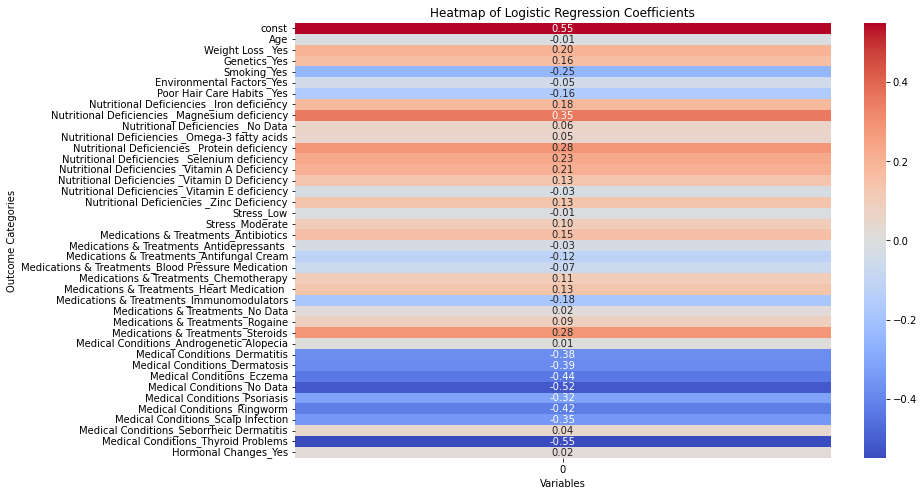

In [24]:
#这一段可能有点问题，不好说
#鉴于卡方检验不显著，探索整体的自变量影响权重
#多元逻辑回归方法确定系数，将各自的系数作为权重在热力图中画出
# 假设 data_new 是已经去掉了 Id 列的数据框
# 定义自变量和因变量
categorical_vars = ["Age", "Weight Loss ", "Genetics","Smoking","Environmental Factors","Poor Hair Care Habits ","Nutritional Deficiencies ",
                    "Stress","Medications & Treatments","Medical Conditions","Hormonal Changes" ]  # 自变量列表
target_var = 'Hair Loss'  # 因变量

# 使用独热编码编码自变量
X = pd.get_dummies(data_new[categorical_vars], drop_first=True)
y = data_new[target_var]

# 添加常数项
X = sm.add_constant(X)

# 训练多元逻辑回归模型
logit_model = sm.MNLogit(y, X).fit()

# 打印模型摘要
print(logit_model.summary())

# 提取回归系数
coefficients = logit_model.params

# 打印回归系数
print(coefficients)

# 设置绘图大小
plt.figure(figsize=(12, 8))

# 绘制热力图
sns.heatmap(coefficients, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Logistic Regression Coefficients")
plt.xlabel('Variables')
plt.ylabel('Outcome Categories')
plt.show()


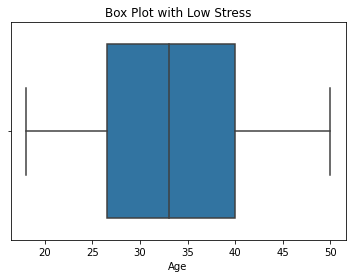

最小值： 18.0 years old
0.25分位数： 26.5 years old
中位数： 33.0 years old
0.75分位数： 40.0 years old
最大值： 50.0 years old


In [25]:
#不同压力水平下脱发情况分析

#DataFrame预处理
data_new1= data[data["Hair Loss"]== 1]

#压力小时的脱发情况分布
dm_1= data_new1[data_new1["Stress"]== "Low"]
plt.figure(figsize=(6,4))
sns.boxplot(x=dm_1["Age"])
plt.title("Box Plot with Low Stress")
plt.xlabel("Age")
plt.show()
print("最小值：", dm_1["Age"].quantile(0), "years old")
print("0.25分位数：", dm_1["Age"].quantile(0.25),"years old")
print("中位数：", dm_1["Age"].quantile(0.5),"years old")
print("0.75分位数：", dm_1["Age"].quantile(0.75),"years old")
print("最大值：", dm_1["Age"].quantile(1),"years old")


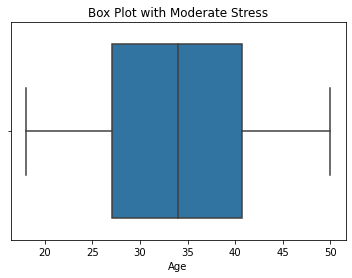

最小值： 18.0 years old
0.25分位数： 27.0 years old
中位数： 34.0 years old
0.75分位数： 40.75 years old
最大值： 50.0 years old


In [26]:
#压力中等时的脱发情况分析
dm_2= data_new1[data_new1["Stress"]== "Moderate"]
plt.figure(figsize=(6,4))
sns.boxplot(x=dm_2["Age"])
plt.title("Box Plot with Moderate Stress")
plt.xlabel("Age")
plt.show()
print("最小值：", dm_2["Age"].quantile(0), "years old")
print("0.25分位数：", dm_2["Age"].quantile(0.25),"years old")
print("中位数：", dm_2["Age"].quantile(0.5),"years old")
print("0.75分位数：", dm_2["Age"].quantile(0.75),"years old")
print("最大值：", dm_2["Age"].quantile(1),"years old")


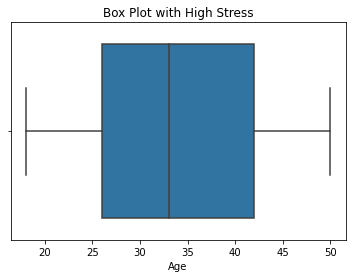

最小值： 18.0 years old
0.25分位数： 26.0 years old
中位数： 33.0 years old
0.75分位数： 42.0 years old
最大值： 50.0 years old


In [27]:
#压力大时的脱发情况分析
dm_3= data_new1[data_new1["Stress"]== "High"]
plt.figure(figsize=(6,4))
sns.boxplot(x=dm_3["Age"])
plt.title("Box Plot with High Stress")
plt.xlabel("Age")
plt.show()
print("最小值：", dm_3["Age"].quantile(0), "years old")
print("0.25分位数：", dm_3["Age"].quantile(0.25),"years old")
print("中位数：", dm_3["Age"].quantile(0.5),"years old")
print("0.75分位数：", dm_3["Age"].quantile(0.75),"years old")
print("最大值：", dm_3["Age"].quantile(1),"years old")


In [28]:
#具体涉及机器学习需要解决的的问题
#划分训练集、验证集、测试集
x= data_new.iloc[:,:-1]
y= data_new.iloc[:,-1]
x_train,x_temp,y_train,y_temp= train_test_split(x,y,test_size=0.3, random_state=42)
x_val,x_test,y_val,y_test= train_test_split(x_temp, y_temp, test_size=1/3, random_state= 42)
print("训练集大小：",x_train.shape,y_train.shape)
print("验证集大小：",x_val.shape,y_val.shape)
print("测试集大小：",x_test.shape,y_test.shape)

训练集大小： (699, 11) (699,)
验证集大小： (200, 11) (200,)
测试集大小： (100, 11) (100,)


In [29]:
#对以上数据集分别进行OneHotEncoder分类变量编码
def encode_categorical_features(x_train, x_val):
    encoder = OneHotEncoder()
    x_train_encoded = encoder.fit_transform(x_train)
    x_val_encoded = encoder.transform(x_val)
    return x_train_encoded, x_val_encoded

# 假设 x_train 和 x_val 已经定义
x_train_encoded, x_val_encoded = encode_categorical_features(x_train, x_val)
print(x_train_encoded.shape)

(699, 81)


In [30]:
#通过三种传统机器学习分类模型训练模型并预测
def train_and_evaluate_models(x_train, y_train, x_val, y_val):
    models={
        "SVM":SVC(),
        "Random Forest":RandomForestClassifier(),
        "XGBoost":XGBClassifier()
    }
    results={}
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred_val= model.predict(x_val)
        accuracy= accuracy_score(y_val, y_pred_val)
        results[name]= accuracy
    return results

results_encoder= train_and_evaluate_models(x_train_encoded, y_train, x_val_encoded, y_val)

print("-----------OneHotEncoder编码方式结果-----------")
for name, accuracy in results_encoder.items():
    #print(f"模型：{name}，验证集准确率：｛accuracy:.4f｝")
    print("模型：",name,"验证集准确率:",accuracy)
    
models= ["SVM","Random Forest","XGBoost"]
accuracy_encoder= [results_encoder[model]for model in models]

-----------OneHotEncoder编码方式结果-----------
模型： SVM 验证集准确率: 0.52
模型： Random Forest 验证集准确率: 0.475
模型： XGBoost 验证集准确率: 0.48


In [31]:
#传统机器学习方法效果并不佳，尝试通过神经网络分类模型并预测，看看准确率能提高多少
#使用FCNN前馈神经网络算法
label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
        
        
# 提取特征和标签
X = data.drop(columns=['Id', 'Hair Loss'])
y = data['Hair Loss']

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 将标签转换为分类格式
y_categorical = to_categorical(y)

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# 建立神经网络模型
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

# 编译模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)

# 评估模型
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/100


D:\Stats\Anaconda\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4912 - loss: 1.0332 - val_accuracy: 0.5250 - val_loss: 0.7539
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5279 - loss: 0.7464 - val_accuracy: 0.5500 - val_loss: 0.6964
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5105 - loss: 0.7031 - val_accuracy: 0.5312 - val_loss: 0.6879
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5034 - loss: 0.7049 - val_accuracy: 0.5375 - val_loss: 0.6882
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5304 - loss: 0.6899 - val_accuracy: 0.5312 - val_loss: 0.6891
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5265 - loss: 0.6976 - val_accuracy: 0.5375 - val_loss: 0.6905
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5463 - loss: 0.6803 - val_accuracy: 0.5437 - val_loss: 0.6915
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5358 - loss: 0.6849 - val_accuracy: 0.5437 - val_loss: 0.6

In [32]:
#一维CNN神经网络算法
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
# 编码分类变量
label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# 提取特征和标签
X = data.drop(columns=['Id', 'Hair Loss'])
y = data['Hair Loss']

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 将标签转换为分类格式
y_categorical = to_categorical(y)

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# 将特征转换为CNN输入所需的形状
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 建立卷积神经网络模型
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

# 编译模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 训练模型
model.fit(X_train_cnn, y_train, epochs=100, batch_size=10, validation_split=0.2)

# 评估模型
loss, accuracy = model.evaluate(X_test_cnn, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/100


D:\Stats\Anaconda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4991 - loss: 0.7118 - val_accuracy: 0.5375 - val_loss: 0.6934
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5062 - loss: 0.7022 - val_accuracy: 0.4688 - val_loss: 0.6946
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5471 - loss: 0.6924 - val_accuracy: 0.4938 - val_loss: 0.6946
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5018 - loss: 0.7056 - val_accuracy: 0.5250 - val_loss: 0.6912
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4724 - loss: 0.7033 - val_accuracy: 0.4938 - val_loss: 0.6939
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4994 - loss: 0.6972 - val_accuracy: 0.4875 - val_loss: 0.6955
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5296 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6993
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5285 - loss: 0.6966 - val_accuracy: 0.4750 - val_loss: 0.6

In [33]:
#带有集合森林的卷积神经网络算法
from sklearn.metrics import accuracy_score
# 创建和训练随机森林模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, np.argmax(y_train, axis=1))

# 评估随机森林模型
rf_predictions = rf.predict(X_test)
rf_accuracy = accuracy_score(np.argmax(y_test, axis=1), rf_predictions)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

# 创建和训练神经网络模型（如前面的CNN模型）
model.fit(X_train_cnn, y_train, epochs=100, batch_size=10, validation_split=0.2)

# 评估神经网络模型
nn_predictions = np.argmax(model.predict(X_test_cnn), axis=1)
nn_accuracy = accuracy_score(np.argmax(y_test, axis=1), nn_predictions)
print(f'Neural Network Accuracy: {nn_accuracy:.4f}')

# 集成结果
ensemble_predictions = (rf_predictions + nn_predictions) / 2
ensemble_predictions = np.round(ensemble_predictions).astype(int)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_predictions)
print(f'Ensemble Accuracy: {ensemble_accuracy:.4f}')

Random Forest Accuracy: 0.5250
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6245 - loss: 0.6560 - val_accuracy: 0.4688 - val_loss: 0.7045
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6344 - loss: 0.6361 - val_accuracy: 0.4812 - val_loss: 0.7116
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5839 - loss: 0.6566 - val_accuracy: 0.5000 - val_loss: 0.7045
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5595 - loss: 0.6899 - val_accuracy: 0.5125 - val_loss: 0.6978
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6054 - loss: 0.6570 - val_accuracy: 0.5063 - val_loss: 0.6999
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6088 - loss: 0.6683 - val_accuracy: 0.5063 - val_loss: 0.7011
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6147 - loss: 0.6572 - val_accuracy: 0.5063 - val_loss: 0.7021
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6051 - loss: 0.

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 188, cost: 6217.0
Run 1, iteration: 2/100, moves: 22, cost: 6210.0
Run 1, iteration: 3/100, moves: 4, cost: 6210.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 217, cost: 6279.0
Run 2, iteration: 2/100, moves: 21, cost: 6270.0
Run 2, iteration: 3/100, moves: 8, cost: 6270.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 135, cost: 6175.0
Run 3, iteration: 2/100, moves: 2, cost: 6175.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 173, cost: 6155.0
Run 4, iteration: 2/100, moves: 98, cost: 6155.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 200, cost: 6214.0
Run 5, iteration: 2/100, moves: 109, cost: 6214.0
Best run 

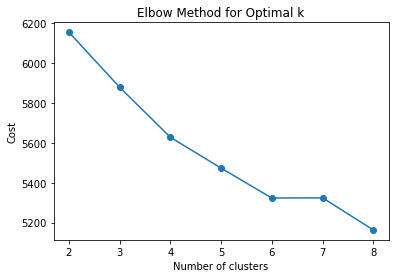

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 136, cost: 5904.0
Run 1, iteration: 2/100, moves: 52, cost: 5904.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 186, cost: 5979.0
Run 2, iteration: 2/100, moves: 145, cost: 5955.0
Run 2, iteration: 3/100, moves: 23, cost: 5955.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 118, cost: 5874.0
Run 3, iteration: 2/100, moves: 45, cost: 5874.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 114, cost: 6062.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 140, cost: 5963.0
Run 5, iteration: 2/100, moves: 133, cost: 5904.0
Run 5, iteration: 3/100, moves: 16, cost: 5904.0
Best run was number 3


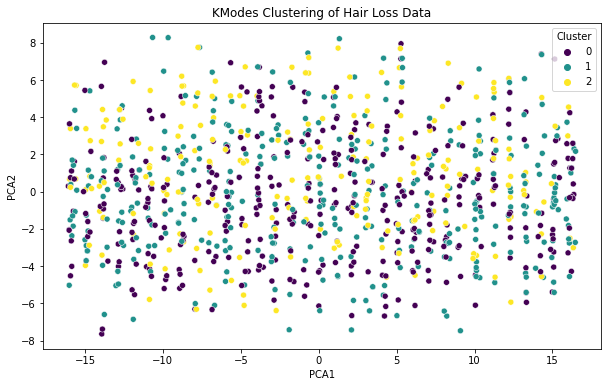

In [34]:
#利用聚类分析，探索数据集内是否存在不同类型的脱发群体
#使用kmodes聚类方法,使用肘部法则来进行判断聚类数量
# 数据预处理
# 假设最后一列是是否脱发，将其分离出来
x2 = data_new.iloc[:, :-1]  # 取所有行，去掉最后一列
y2 = data_new.iloc[:, -1]   # 取最后一列

# 对每个分类变量进行编码
label_encoders = {}
for column in x2.columns:
    le = LabelEncoder()
    x2[column] = le.fit_transform(x2[column])
    label_encoders[column] = le

# 3. 使用K-modes算法进行聚类
# 尝试不同的聚类数目，这里假设我们尝试2到6个群体
costs = []
for k in range(2, 9):
    kmodes = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1)
    clusters = kmodes.fit_predict(x2)
    costs.append(kmodes.cost_)

# 找出最合适的聚类数目（拐点法）
plt.plot(range(2, 9), costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

# 选择合适的k（假设我们选择3）
kmodes = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = kmodes.fit_predict(x2)

# 将聚类结果添加回原数据框
data_new['Cluster'] = clusters

# 4. 可视化聚类结果
# 使用PCA将数据降到2维以便可视化
pca = PCA(n_components=2)
x2_pca = pca.fit_transform(x2)

data_new['PCA1'] = x2_pca[:, 0]
data_new['PCA2'] = x2_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data_new, palette='viridis')
plt.title('KModes Clustering of Hair Loss Data')
plt.show()


In [35]:
data_new= data_new.drop("Cluster", axis=1)
data_new= data_new.drop("PCA1", axis=1)
data_new= data_new.drop("PCA2", axis=1)
data_new

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...
994,Yes,No,Seborrheic Dermatitis,Rogaine,Vitamin A Deficiency,Low,33,Yes,Yes,Yes,Yes,1
995,Yes,Yes,No Data,Accutane,Protein deficiency,Low,47,No,No,No,Yes,0
996,No,Yes,Androgenetic Alopecia,Antidepressants,Protein deficiency,Moderate,20,Yes,No,Yes,Yes,1
997,No,Yes,Dermatitis,Immunomodulators,Biotin Deficiency,Moderate,32,Yes,Yes,Yes,Yes,1


In [36]:
#使用xgboost算法，识别出最能预测脱发的关键因素
#定义并训练XGBoost模型
# 分离特征和目标变量
x1 = data_new.drop('Hair Loss', axis=1)  # 假设最后一列是脱发与否的标签
y1 = data_new['Hair Loss']

# 使用LabelEncoder将分类特征转换为数值型数据
label_encoders = {}
for column in x1.columns:
    if x1[column].dtype == 'object':
        le = LabelEncoder()
        x1[column] = le.fit_transform(x1[column])
        label_encoders[column] = le

# 将数据分为训练集和测试集（这里使用70%的数据用于训练，30%用于测试）
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x1, y1, test_size=0.3, random_state=42)

# 初始化XGBoost分类器
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# 训练模型
model.fit(x_train_1, y_train_1)

# 可视化特征的重要性
#plot_importance(model)
#plt.show()

# 获取具体的特征重要性数值
importances = model.feature_importances_

features = x1.columns
importance_dict = dict(zip(features, importances))

# 按照重要性降序排序
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance:
    print(f"{feature}:{importance}") 
    
#for col, imp in zip(x1.columns, importances):
    #print(f"{col}: {imp}")
    

Hormonal Changes:0.10443790256977081
Stress:0.1001628115773201
Medications & Treatments:0.09997633099555969
Medical Conditions:0.09741736948490143
Nutritional Deficiencies :0.09670936316251755
Age:0.09155911952257156
Environmental Factors:0.08961912244558334
Poor Hair Care Habits :0.08599625527858734
Weight Loss :0.07960952818393707
Smoking:0.078565813601017
Genetics:0.07594631612300873


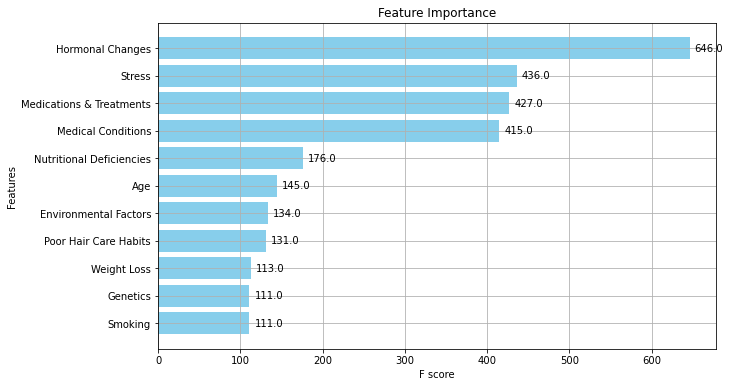

In [37]:
#总体自变量影响权重分析图表可视化
data_old= {
    "Feature":[
        "Hormonal Changes","Stress","Medications & Treatments",
        "Medical Conditions","Nutritional Deficiencies",
        "Age","Environmental Factors","Poor Hair Care Habits",
        "Weight Loss","Smoking","Genetics"
    ],
    "Importance":[646.0,436.0,427.0,
                 415.0,176.0,145.0,134.0,131.0,113.0,
                 111.0,111.0]
}

dk= pd.DataFrame(data_old)

dk= dk.sort_values(by="Importance", ascending= True)

plt.figure(figsize=(10,6))
bars= plt.barh(dk["Feature"],
               dk["Importance"], color="skyblue")

for bar in bars:
    plt.annotate(f"{bar.get_width()}",
                xy=(bar.get_width(),bar.get_y()+bar.get_height()/2),xytext=(5,0),
                textcoords="offset points",
                ha= "left",va="center")
plt.xlabel("F score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.grid(True)
plt.show()


